##**Diffusion Equation Analysis on the Stanford Bunny Mesh**

In this work we will see an analysis of the Diffusion Equation over the Stanford's Bunny Mesh Dataset.

Why this? Well, because we love Mathematics, and, most importantly, bunnies are cute

### Importing the dataset

We can easily import the required data by executing these few lines

In [1]:
# Install torch_geometric, and trimesh
!pip install torch_geometric
!pip install trimesh
# Download the Stanford Bunny dataset
!wget http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz
!tar -xvzf bunny.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.6/694.6 kB 5.3 MB/s eta 0:00:00
--2024-06-01 13:02:01--  http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz
Resolving graphics.stanford.edu (graphics.stanford.edu)... 171.67.77.70
Connecting to graphics.stanford.edu (graphics.stanford.edu)|171.67.77.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4894286 (4.7M) [application/x-gzip]
Saving to: ‘bunny.tar.gz’

bunny.tar.gz        100%[===================>]   4.67M  1.62MB/s    in 2.9s    

2024-06-01 13:02:04 (1.62 MB/s) - ‘bunny.tar.gz’ saved [4894286/4894286]

bunny/
bunny/data/
bunny/data/README
bunny/data/bun.conf
bunny/data/bun.conf~
bunny/data/bun000.ply
bunny/data/bun045.ply
bunny/data/bun090.ply
bunny/data/bun180.ply
bunny/data/bun270.ply
bunny/data/bun315.ply
bunny/data/chin.ply
bunny/data/ear_back.ply
bunny/data/top2.ply
bunny/data/top3.ply
bunny/reconstruction/
bunny/r

In [2]:
import trimesh

# Load the bunny mesh
bunny_mesh = trimesh.load_mesh('bunny/reconstruction/bun_zipper.ply')

# Print some information about the mesh
print(bunny_mesh)

# If you want to visualize the mesh (this will work in Jupyter notebooks)
bunny_mesh.show()

<trimesh.Trimesh(vertices.shape=(34834, 3), faces.shape=(69451, 3), name=`bun_zipper.ply`)>


By importing this repository, you obtain also a dataset that we'll use later

In [3]:
from getpass import getpass
token = getpass('Enter your GitHub token: ')

Enter your GitHub token: ··········


In [3]:
# !git clone https://$token@github.com/YuriPaglierani/Diffusion_Equation_Analysis_Stanford_Bunny_Mesh.git
!git clone https://github.com/YuriPaglierani/Diffusion_Equation_Analysis_Stanford_Bunny_Mesh.git

Cloning into 'Diffusion_Equation_Analysis_Stanford_Bunny_Mesh'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 103 (delta 14), reused 27 (delta 6), pack-reused 64
Receiving objects: 100% (103/103), 55.04 MiB | 27.82 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
%cd /content/Diffusion_Equation_Analysis_Stanford_Bunny_Mesh

/content/Diffusion_Equation_Analysis_Stanford_Bunny_Mesh


In [8]:
import os
import numpy as np
import torch
import torch_geometric
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from typing import Tuple
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from torch_geometric.nn import GCNConv
from matplotlib import colormaps
from torch_geometric.utils import to_undirected, remove_self_loops, get_laplacian

Now, let's obtain the required edges, and try to find some info

In [9]:
def get_edges(vertices: torch.Tensor, faces: torch.Tensor) -> torch.Tensor:
    """
    Given vertices and faces of a mesh, return the tensor of edges.

    Args:
        vertices (torch.Tensor): Tensor of shape (V, 3) representing the vertices of the mesh.
        faces (torch.Tensor): Tensor of shape (F, 3) representing the faces of the mesh (triangular meshes).

    Returns:
        torch.Tensor: Tensor of shape (2, E) representing the edges of the mesh.
    """
    # Initialize an empty set to store edges
    edges = set()

    # Iterate over each face to find the edges
    for face in faces:
        edges.add(tuple(sorted([face[0].item(), face[1].item()])))
        edges.add(tuple(sorted([face[1].item(), face[2].item()])))
        edges.add(tuple(sorted([face[2].item(), face[0].item()])))

    # Convert the set of edges to a PyTorch tensor and transpose it to shape (2, E)
    edges_tensor = torch.tensor(list(edges), dtype=torch.long).t().contiguous()

    return edges_tensor

# Get the vertices, and faces
vertices = torch.tensor(bunny_mesh.vertices, dtype=torch.float32)
faces = torch.tensor(bunny_mesh.faces, dtype=torch.long)

# Get edges from vertices, and faces
edges = get_edges(vertices, faces)

In [10]:
# Make sure edges are undirected and have no self-loops
edge_index = to_undirected(edges)
edge_index, _ = remove_self_loops(edge_index)

In [11]:
print(f"Number of Nodes: {vertices.shape[0]}")
print(f"Number of Undirected Edges: {edge_index.shape[1]//2}")

Number of Nodes: 34834
Number of Undirected Edges: 104288


First of all, let's inspect the degree of nodes in the graph, that can be interesting because we can get some usefule information.

For example, the node degree tells us how many neighbors has each node.

Average Degree: 5.99


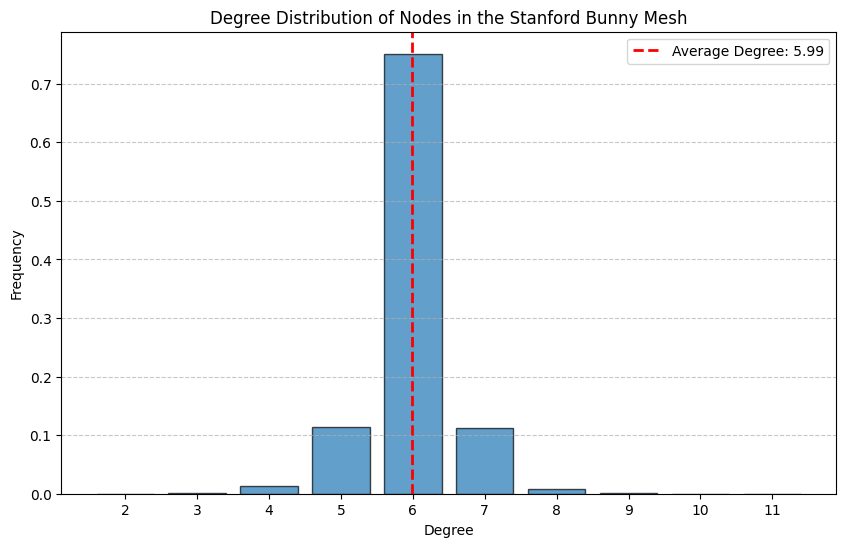

In [12]:
num_nodes = vertices.shape[0]
degree_vector = torch.zeros(num_nodes, dtype=torch.long)

# Count the degree of each node
degree_vector.scatter_add_(0, edge_index[0], torch.ones(edge_index.shape[1], dtype=torch.long))

# Calculate the average degree
avg_degree = edge_index.shape[1] / vertices.shape[0]

print(f"Average Degree: {avg_degree:.2f}")

# Make the Bar Plot
unique_degrees, counts = np.unique(degree_vector.numpy(), return_counts=True)

# Plot the degree distribution using a bar plot
plt.figure(figsize=(10, 6))
plt.bar(unique_degrees, counts / counts.sum(), edgecolor='black', alpha=0.7)

# Add a vertical red line for the average degree
plt.axvline(avg_degree, color='red', linestyle='--', linewidth=2, label=f'Average Degree: {avg_degree:.2f}')

# Add title and labels
plt.title('Degree Distribution of Nodes in the Stanford Bunny Mesh')
plt.xlabel('Degree')
plt.xticks(np.arange(unique_degrees.min(), unique_degrees.max() + 1, 1))
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [13]:
degree_ratio = avg_degree / (vertices.shape[0] - 1)
print(f"degree_ratio: {degree_ratio:.5f}")

degree_ratio: 0.00017


These info are important because it tells us that the degree_ratio is << 1, so we have a sparse graph

For this problem however, we have a weighted graph, weights depends on the spatial distance among nodes, in particular there is an inverse dependence, because nodes that are near can exchange information (or temperature) faster then the ones that are far from each others

In [14]:
weights_dist = vertices[edge_index]
weights_dist = 1/torch.norm(weights_dist[0] - weights_dist[1], dim=-1)
weights_dist /= weights_dist.mean() # we can do this easily because all the weights are positive

In [15]:
edge_index, edge_weight = get_laplacian(edge_index, edge_weight=weights_dist)
laplacian_matrix = torch.sparse_coo_tensor(edge_index, edge_weight, (num_nodes, num_nodes)) # sparse Graph Laplace Operator

In [16]:
edge_index.shape[1] # Now, we have added also self loops, so we have more edges

243410

In [17]:
def normalizer(input_tensor:torch.Tensor) -> torch.Tensor:
    """
    Normalize the input tensor to be within the range [min_val, max_val].

    Args:
        input_tensor (torch.Tensor): The input tensor to be normalized.

    Returns:
        torch.Tensor: The normalized tensor.
    """

    # Normalize input_tensor to the range [0, 1]
    tensor_min = input_tensor.min(dim=1, keepdim=True).values
    tensor_max = input_tensor.max(dim=1, keepdim=True).values
    normalized_tensor = (input_tensor - tensor_min) / (tensor_max - tensor_min)

    return normalized_tensor

In [18]:
simulations = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

temperatures = torch.zeros([simulations, vertices.shape[0], 1])
max_T = 1
temperatures[0] = max_T * torch.sin(40*vertices.sum(axis=1) ).reshape(-1, 1) # -1/2 =< T =< 1/2
temperatures[1] = max_T * torch.tanh(-20*vertices.sum(axis=1)).reshape(-1, 1)
temperatures[2] = max_T * torch.cos(30 * vertices.sum(axis=1)).reshape(-1, 1)
temperatures[3] = (30 * vertices.sum(axis=1)*vertices.sum(axis=1)).reshape(-1, 1)
temperatures += (0.05*torch.randn(temperatures.shape))
temperatures = max_T*(normalizer(temperatures)).to(device)

torch.manual_seed(42)
# select randomly some points that will satisfy the Dirichlet's B. Condition
fixed_points = torch.randperm(num_nodes, dtype=torch.int64)[:(num_nodes//100)*simulations].reshape(simulations, -1).to(device)

def set_fixed_points(target:torch.Tensor, fixed_points:torch.Tensor, value:float) -> torch.Tensor:
    scatter_indices = fixed_points.unsqueeze(-1).expand(-1, -1, 1)
    return target.scatter_(1, scatter_indices, value)

temperatures = set_fixed_points(temperatures, fixed_points, max_T)

In [19]:
extremes = torch.tensor([temperatures.min(), temperatures.max()], dtype=float)

In [20]:
def plot_bunny(mesh:trimesh.base.Trimesh, color_scale:torch.Tensor, extremes:torch.Tensor) -> torch.Tensor:
    """
    Plots a 3D mesh of a bunny with a given color scale.

    Args:
        mesh (trimesh.base.Trimesh): The 3D mesh of the bunny to be plotted.
        color_scale (torch.Tensor): A tensor containing the values used to color the mesh vertices.
        extremes (torch.Tensor): A tensor containing the minimum and maximum values for normalization.

    Returns:
        torch.Tensor: The plotted mesh.
    """

    extremes = extremes.cpu()
    norm = plt.Normalize(vmin=extremes.min(), vmax=extremes.max())

    cmap = colormaps['coolwarm']
    colors = cmap(norm(color_scale.reshape(-1).cpu()))

    mesh.visual.vertex_colors = (colors[:, :3] * 255).astype(np.uint8)  # Convert to RGB values
    return mesh.show()


plot_bunny(bunny_mesh, temperatures[0], extremes)

In [21]:
temperatures = temperatures.reshape(simulations, -1, 1).to(device)

D = 0.3  # Diffusion coefficient
dt = 0.1  # Time step
timesteps = 1000  # Number of time steps to simulate
laplacian_matrix = laplacian_matrix.to(device)


# Diffusion step function
def diffusion_step(T:torch.Tensor, D:float, dt:float, laplacian:torch.Tensor, fixed_points:torch.Tensor) -> torch.Tensor:
    """
    Performs a single diffusion step on the temperature tensor T using the diffusion coefficient D,
    time step dt, and the Laplacian matrix, keeping the Dirichlet B.C.

    Args:
        T (torch.Tensor): The current temperature tensor of shape (N, 1), where N is the number of nodes.
        D (torch.Tensor): The diffusion coefficient tensor.
        dt (torch.Tensor): The time step tensor.
        laplacian (torch.Tensor): The Laplacian matrix tensor of shape (N, N) in sparse format.
        fixed_points (torch.Tensor): The indices of points that should remain fixed.

    Returns:
        torch.Tensor: The updated temperature tensor after one diffusion step.
    """
    dT = - torch.sparse.mm(laplacian, T) * dt * D # torch.vmap doesn't support sparse.mm for the moment :(
    dT[fixed_points] = torch.tensor([0], dtype=torch.float32).to(device) # ensure fixed_points remain the same
    return T + dT

# Simulate diffusion
T = temperatures.clone().detach()
for t in range(timesteps):
    T = torch.vmap(diffusion_step, in_dims=(0, None, None, None, 0))(T, D, dt, laplacian_matrix, fixed_points)

print("Diffusion simulation complete.")
plot_bunny(bunny_mesh, T[0], extremes)

<ipython-input-21-6952ef2cbce0>:25: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_sparse_mm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  dT = - torch.sparse.mm(laplacian, T) * dt * D # torch.vmap doesn't support sparse.mm for the moment :(


Diffusion simulation complete.


### Building the dataset

Here, we will make a simulation with a "small" dt, moreover every 400 steps we will save a snapshot

In [22]:
dt_small = 0.1 / 20 # integration step
snap_step = 400 # save a snapshot every 400 steps
timesteps = 20000 # rollout duration

print(f"Single dt step: {dt_small:.3f} seconds")
print(f"Time between snapshots: {snap_step*dt_small:.1f} seconds")
print(f"Duration of the simulation: {(timesteps*dt_small):.1f} seconds")
print(f"Number of Simulations: {simulations}")

Single dt step: 0.005 seconds
Time between snapshots: 2.0 seconds
Duration of the simulation: 100.0 seconds
Number of Simulations: 4


In [23]:
file_path = 'diffusion_dataset.pt'
if not os.path.exists(file_path):
    # Simulate 20000 steps and save data every 800 steps
    dataset = torch.zeros((simulations, timesteps//snap_step, num_nodes, 1), dtype=torch.float32)

    T = temperatures

    for t in tqdm(range(timesteps)):
        T = torch.vmap(diffusion_step, in_dims=(0, None, None, None, 0))(T, D, dt_small, laplacian_matrix, fixed_points)
        if t % snap_step == 0:
            dataset[:, t//snap_step, :, :] = T

    torch.save(dataset, 'diffusion_dataset.pt')
    print("Dataset creation completed.")

else:
    dataset = torch.load(file_path)
    print(" Dataset loaded successfully.")


 Dataset loaded successfully.


### MSE of the coarse simulation (if exists)

Objective: we want to take higher timesteps in order to speed-up the simulation, so let's try with a dt_new equal to 2.0 seconds (the interval between a step and the next one), moreover, let's compute the MSE between the true simulation, and the one with the bigger step

In [24]:
# Define the new diffusion step function with dt_new
dt_big = snap_step * dt_small

criterion = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = dataset.to(device)
laplacian_matrix = laplacian_matrix.to(device)
fixed_points = fixed_points.to(device)
dt_big = torch.tensor(dt_big, dtype=torch.float32).to(device)
D = torch.tensor(D, dtype=torch.float32).to(device)

benchmark_loss = 0

history_euler = []
T_pred = dataset[:, 0]
for i in range(dataset.shape[1] - 1):
    T_true = dataset[:, i + 1]  # True temperature distribution at next step
    T_pred = torch.vmap(diffusion_step, in_dims=(0, None, None, None, 0))(T_pred, D, dt_big, laplacian_matrix, fixed_points)
    # Compute the loss
    loss = criterion(T_pred, T_true)
    benchmark_loss += (loss.item() - benchmark_loss) / (i+1) # average loss through space and time
    history_euler.append(benchmark_loss)

    print(f"step {i+1}: {benchmark_loss}")

step 1: 0.011404761113226414
step 2: 0.07441138895228505
step 3: 0.8107632774238785
step 4: 12.389959512511268
step 5: 307.39539046157154
step 6: 15700.897200384643
step 7: 1329317.7690289011
step 8: 135418353.0479003
step 9: 14685909888.931469
step 10: 1638516305498.4382
step 11: 185966775946508.4
step 12: 2.1363043637236044e+16
step 13: 2.4767663967642225e+18
step 14: 2.8925788334683875e+20
step 15: 3.3985210665885862e+22
step 16: 4.01307289332353e+24
step 17: 4.759111202143285e+26
step 18: 5.664823111066489e+28


<ipython-input-21-6952ef2cbce0>:25: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_sparse_mm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  dT = - torch.sparse.mm(laplacian, T) * dt * D # torch.vmap doesn't support sparse.mm for the moment :(


step 19: 6.764870562137308e+30
step 20: inf
step 21: nan
step 22: nan
step 23: nan
step 24: nan
step 25: nan
step 26: nan
step 27: nan
step 28: nan
step 29: nan
step 30: nan
step 31: nan
step 32: nan
step 33: nan
step 34: nan
step 35: nan
step 36: nan
step 37: nan
step 38: nan
step 39: nan
step 40: nan
step 41: nan
step 42: nan
step 43: nan
step 44: nan
step 45: nan
step 46: nan
step 47: nan
step 48: nan
step 49: nan


What happened here? Is there a bug?

When we increased the step size, we unintentionally violated the Courant-Friedrichs-Lewy (CFL) condition, that for the Heat equation in a mesh is
$$\Delta t \leq \frac{2}{D\cdot\lambda_{max}}$$
Where $\lambda_{max}$ is the max eigenvalue of the Graph Laplace Matrix.

We can check that for dt_big = 400 small_dt this condition doesn't hold anymore (power method).

In [25]:
def power_method_sparse(matrix:torch.Tensor, num_iterations:int=100, tol:float=1e-6) -> Tuple :
    # Initialize a random vector
    b_k = torch.rand(matrix.shape[1], device=matrix.device)

    for _ in range(num_iterations):
        # Multiply by the matrix
        b_k1 = torch.sparse.mm(matrix, b_k.view(-1, 1)).view(-1)

        # Normalize the vector
        b_k1_norm = torch.norm(b_k1)
        if b_k1_norm == 0:
            raise ValueError("Encountered zero vector during power iteration.")

        b_k1 = b_k1 / b_k1_norm

        # Check for convergence
        if torch.norm(b_k1 - b_k) < tol:
            print("Power Method Converged!")
            break

        b_k = b_k1

    # Rayleigh quotient to find the maximum eigenvalue
    max_eigenvalue = torch.dot(b_k, torch.sparse.mm(matrix, b_k.view(-1, 1)).view(-1)) / torch.dot(b_k, b_k)

    return max_eigenvalue.item(), b_k

# Apply the power method
max_eigenvalue, eigenvector = power_method_sparse(laplacian_matrix)
print(f"Max Eigenvalue of the Laplacian: {max_eigenvalue:.1f}")

Power Method Converged!
Max Eigenvalue of the Laplacian: 20.4


In [26]:
dt_cfl = 2/(D*max_eigenvalue)
print(f"Max dt allowed: {dt_cfl:.3}")
print(f"dt_big used: {dt_big}")
print(f"CFL violated? {dt_big > dt_cfl}")

Max dt allowed: 0.327
dt_big used: 2.0
CFL violated? True


### Experiment in stable regime
Now we know the CFL condition, we can try by using a new $\Delta$t that satisfies it, and such that $\Delta t_{small} < \Delta t_{new} < \Delta t_{big}$

In [27]:
# Define the new diffusion step function with dt_new = 0.25
snap_step_euler = 50
dt_new = snap_step_euler * dt_small
latent_iter = snap_step // snap_step_euler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = dataset.to(device)
laplacian_matrix = laplacian_matrix.to(device)
fixed_points = fixed_points.to(device)
history_euler_stable = []
benchmark_loss = 0

T_pred = dataset[:, 0]
for i in range(dataset.shape[1]-1):
    T_true = dataset[:, i + 1]  # True temperature distribution at next step

    # Now, for each comparison, we need 16 steps
    for _ in range(latent_iter):
        T_pred = torch.vmap(diffusion_step, in_dims=(0, None, None, None, 0))(T_pred, D, dt_new, laplacian_matrix, fixed_points)

    # Compute the loss
    loss = criterion(T_pred, T_true)
    benchmark_loss += (loss.item() - benchmark_loss) / (i+1)
    history_euler_stable.append(benchmark_loss)
    print(f"step {i+1}: {benchmark_loss:.7f}")

print(f"-------------------------------------")
print(f"Max dt allowed: {dt_cfl:.7f}")
print(f"dt_new used: {dt_new}")
print(f"CFL violated? {dt_new > dt_cfl}")

step 1: 0.0000025
step 2: 0.0000018
step 3: 0.0000014
step 4: 0.0000012
step 5: 0.0000010


<ipython-input-21-6952ef2cbce0>:25: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_sparse_mm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  dT = - torch.sparse.mm(laplacian, T) * dt * D # torch.vmap doesn't support sparse.mm for the moment :(


step 6: 0.0000009
step 7: 0.0000008
step 8: 0.0000007
step 9: 0.0000007
step 10: 0.0000006
step 11: 0.0000006
step 12: 0.0000005
step 13: 0.0000005
step 14: 0.0000005
step 15: 0.0000005
step 16: 0.0000004
step 17: 0.0000004
step 18: 0.0000004
step 19: 0.0000004
step 20: 0.0000004
step 21: 0.0000004
step 22: 0.0000003
step 23: 0.0000003
step 24: 0.0000003
step 25: 0.0000003
step 26: 0.0000003
step 27: 0.0000003
step 28: 0.0000003
step 29: 0.0000003
step 30: 0.0000003
step 31: 0.0000003
step 32: 0.0000003
step 33: 0.0000003
step 34: 0.0000003
step 35: 0.0000003
step 36: 0.0000002
step 37: 0.0000002
step 38: 0.0000002
step 39: 0.0000002
step 40: 0.0000002
step 41: 0.0000002
step 42: 0.0000002
step 43: 0.0000002
step 44: 0.0000002
step 45: 0.0000002
step 46: 0.0000002
step 47: 0.0000002
step 48: 0.0000002
step 49: 0.0000002
-------------------------------------
Max dt allowed: 0.3270877
dt_new used: 0.25
CFL violated? False


As you can see, now we are slower than the case with $\Delta t_{big}$ because we have increased the number of steps required, but at the same time now we can rely on a good result.

### **Chebyshev Network**

Now we've seen that the classic operator requires 16 steps per every observed one, let's try to find an operator that tries to mimics the original one, and at the same time fits with the data.

Let's start with the Chebyshev Network.

In [28]:
dists = vertices[edge_index]
dists = torch.norm(dists[0] - dists[1], dim=-1)
idx = dists > 1e-9
dists[idx] = 1/dists[idx]
dists /= dists[idx].mean()

The Chebyshev Network is strongly related to Chebyshev Polynomials

$$C_{n+1}(x) = 2x\cdot C_n - C_{n-1}, \qquad C_0(x) = 1, \qquad C_1(x) = x$$

We can approximate a function $f$ defined in $\left[-1, 1\right]$ by taking a linear combination of the Chebyshev coefficients

$$f(x) = \sum_{k=0}^N \theta_k C_{k}(x)$$

For our task the goal will be to approximate the unstable operator $$V = I - \Delta t \cdot D\cdot L$$

To have a well defined operator $V$ we need that its eigenvalues are bounded in $\left[-1, 1\right]$

So, we define

$$\tilde{V} = \frac{2\left(I - \Delta t \cdot D \cdot L\right)}{\lambda_{max}(V)} - I$$

Now, our Chebyshev Network will compute

$$f(\tilde{V}) = \sum_{k=0}^3\theta_k C_k(\tilde{V})$$

So

$$T^{n+1} = f(\tilde{V})\cdot T^n$$

In [29]:
class Cheb_Diffusion_Net(nn.Module):
    def __init__(self, laplacian_matrix:torch.Tensor,
                 dt:torch.Tensor, D:torch.Tensor,
                 K:int=3, in_features:int=1, out_features:int=1):
        super(Cheb_Diffusion_Net, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.K = K

        # Normalize the diffusion operator using the given Laplacian matrix
        self.V_tilde = self.normalize_diffusion_operator(laplacian_matrix, dt, D)

        # Initialize weights for Chebyshev polynomials
        self.weight = nn.Parameter(torch.Tensor(K + 1, in_features, out_features))

        # Reset parameters to initialize weights properly
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize the parameters of the network.
        """
        nn.init.uniform_(self.weight, a=-0.5, b=0.5)

    def normalize_diffusion_operator(self, laplacian_matrix:torch.Tensor,
                                     dt:torch.Tensor, D:torch.Tensor):
        """
        Normalize the diffusion operator based on the Laplacian matrix.
        """
        size = laplacian_matrix.shape[0]

        # Create a sparse identity matrix
        indices = torch.arange(size).repeat(2, 1)
        values = torch.ones(size)
        identity_sparse = torch.sparse_coo_tensor(indices, values, (size, size)).to(laplacian_matrix.device)

        # Calculate the diffusion operator
        V = identity_sparse - laplacian_matrix * dt * D

        # Find the maximum eigenvalue using the power method
        max_eigenvalue = torch.abs(self.power_method_sparse(V))

        return 2*V/max_eigenvalue - identity_sparse

    def power_method_sparse(self, matrix:torch.Tensor,
                            num_iterations:int=100, tol:float=1e-6):

        # Initialize a random vector
        b_k = torch.rand(matrix.shape[1], device=matrix.device)

        for _ in range(num_iterations):
            # Multiply by the matrix
            b_k1 = torch.sparse.mm(matrix, b_k.view(-1, 1)).view(-1)

            # Normalize the vector
            b_k1_norm = torch.norm(b_k1)
            if b_k1_norm == 0:
                raise ValueError("Encountered zero vector during power iteration.")

            b_k1 = b_k1 / b_k1_norm

            # Check for convergence
            if torch.norm(b_k1 - b_k) < tol:
                print("Power Method Converged!")
                break

            b_k = b_k1

        # Rayleigh quotient to find the maximum eigenvalue
        max_eigenvalue = torch.dot(b_k, torch.sparse.mm(matrix, b_k.view(-1, 1)).view(-1)) / torch.dot(b_k, b_k)

        return max_eigenvalue

    def forward(self, x:torch.Tensor):
        # Compute the Chebyshev polynomials up to order K
        num_nodes = x.shape[0]
        Tx_0 = x
        Tx_1 = torch.sparse.mm(self.V_tilde, x)
        out = Tx_1 * self.weight[1]

        for k in range(2, self.K + 1):
            Tx_2 = 2 * torch.sparse.mm(self.V_tilde, Tx_1) - Tx_0
            out = out + Tx_2 * self.weight[k]
            Tx_0, Tx_1 = Tx_1, Tx_2

        out = Tx_0 * self.weight[0] + out

        return out

In [30]:
def train(net:nn.Module, optimizer:Optimizer,
          scheduler:_LRScheduler, criterion:nn.Module,
          dataset:torch.Tensor, checkpoint_path:str,
          max_T:float, threshold:float=100,
          num_epochs:int=1000, device:str='cpu', train:bool=True):

    # Variables to track the best model
    max_i = -1
    min_loss = float('inf')


    # Load checkpoint if it exists
    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        net.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print("Checkpoint loaded.")

    if not train:
        return

    for epoch in tqdm(range(num_epochs)):

        net.train()
        optimizer.zero_grad()  # Reset gradients at the beginning of each epoch
        epoch_loss = 0

        T_pred = dataset[:, 0]

        for i in range(dataset.shape[1] - 1):
            T_true = dataset[:, i + 1]  # True temperature distribution at next step

            T_pred = torch.vmap(net, in_dims=(0))(T_pred)
            T_pred = set_fixed_points(T_pred, fixed_points, max_T)

            # Compute the loss
            loss = criterion(T_pred, T_true)

            epoch_loss += (loss.item() - epoch_loss) / (i+1)
            # print(epoch_loss)
            if epoch_loss > threshold:
                loss.backward(retain_graph=False)  # Delete the graph when you reach this point
                clip_grad_norm_(net.parameters(), clip_value)

                if i > max_i or (i == max_i and epoch_loss < min_loss):
                    max_i = i
                    min_loss = epoch_loss
                    print(f"i max: {i}")
                    # Save the model checkpoint
                    torch.save(net.state_dict(), checkpoint_path)
                break

            loss.backward(retain_graph=True if i < dataset.shape[1] - 2 else False)  # Save computational graph
            clip_grad_norm_(net.parameters(), clip_value)

        for param in smoothed_network.parameters():
            if param.grad is not None:
                param.grad.data /= i+1
        optimizer.step()  # Update the model parameters after accumulating gradients
        # Step the scheduler
        scheduler.step()
        # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss }')

    print("Training complete.")
    print(f"max_i reached during training: {max_i}")
    print(f"best loss: {min_loss:.2f}")

In [31]:
dt_new = snap_step * dt_small
# Load the dataset
dataset = torch.load('diffusion_dataset.pt')
laplacian_matrix = laplacian_matrix.to(device)
smoothed_network = Cheb_Diffusion_Net(laplacian_matrix, dt_new, D, K=4)
# Define the optimizer
optimizer = torch.optim.AdamW(smoothed_network.parameters(), lr=0.01)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.97)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
smoothed_network = smoothed_network.to(device)
dataset = dataset.to(device)
fixed_points = fixed_points.to(device)
clip_value = 1.0
checkpoint_path = 'best_cheb_network_checkpoint.pt'

train(smoothed_network, optimizer, scheduler, criterion, dataset, checkpoint_path, max_T, num_epochs=150, threshold=0.2, train=False)

Loading checkpoint...
Checkpoint loaded.


In [32]:
benchmark_loss_smoothed = 0
benchmark_loss_constant = 0

smoothed_network.eval()
T_pred_smoothed = dataset[:, 0]
T_pred_euler = dataset[:, 0]
history_smoothed = []
history_constant = []

roll = dataset.shape[1] - 1

# Evaluation loop with no_grad context
with torch.no_grad():
    for i in range(roll):
        T_true = dataset[:, i + 1]  # True temperature distribution at next step

        T_pred_smoothed = torch.vmap(smoothed_network, in_dims=(0))(T_pred_smoothed)
        T_pred_smoothed = set_fixed_points(T_pred_smoothed, fixed_points, max_T)

        # Compute the loss
        loss_smoothed = criterion(T_pred_smoothed, T_true)

        loss_constant = criterion(T_true, dataset[:, 0])

        benchmark_loss_smoothed += (loss_smoothed.item() - benchmark_loss_smoothed) / (i+1)
        benchmark_loss_constant += (loss_constant.item() - benchmark_loss_constant) / (i+1)

        history_smoothed.append(benchmark_loss_smoothed)
        history_constant.append(benchmark_loss_constant)

        print(f"step {i+1}: {benchmark_loss_smoothed:.3f}")

step 1: 0.001
step 2: 0.002
step 3: 0.003
step 4: 0.004
step 5: 0.004
step 6: 0.005
step 7: 0.006
step 8: 0.007


<ipython-input-29-bffe5d0d5ed3>:79: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_sparse_mm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  Tx_1 = torch.sparse.mm(self.V_tilde, x)
<ipython-input-29-bffe5d0d5ed3>:83: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_sparse_mm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  Tx_2 = 2 * torch.sparse.mm(self.V_tilde, Tx_1) - Tx_0


step 9: 0.008
step 10: 0.009
step 11: 0.010
step 12: 0.011
step 13: 0.012
step 14: 0.013
step 15: 0.014
step 16: 0.016
step 17: 0.017
step 18: 0.018
step 19: 0.019
step 20: 0.020
step 21: 0.021
step 22: 0.023
step 23: 0.024
step 24: 0.025
step 25: 0.027
step 26: 0.028
step 27: 0.029
step 28: 0.031
step 29: 0.032
step 30: 0.033
step 31: 0.035
step 32: 0.036
step 33: 0.038
step 34: 0.039
step 35: 0.041
step 36: 0.043
step 37: 0.045
step 38: 0.047
step 39: 0.050
step 40: 0.053
step 41: 0.057
step 42: 0.062
step 43: 0.068
step 44: 0.077
step 45: 0.089
step 46: 0.106
step 47: 0.130
step 48: 0.165
step 49: 0.215


In [33]:
rmse_chebyshev_final = torch.sqrt(torch.tensor([history_smoothed[-1]]))
print(f"Final RMSE Chebyshev: {rmse_chebyshev_final.item():.2f}")

Final RMSE Chebyshev: 0.46


Notice that also the Chebyshev operator violated the CFL condition, but the dynamics diverges slower, that means that we adaptated the operator to work with an higher dt_cfl

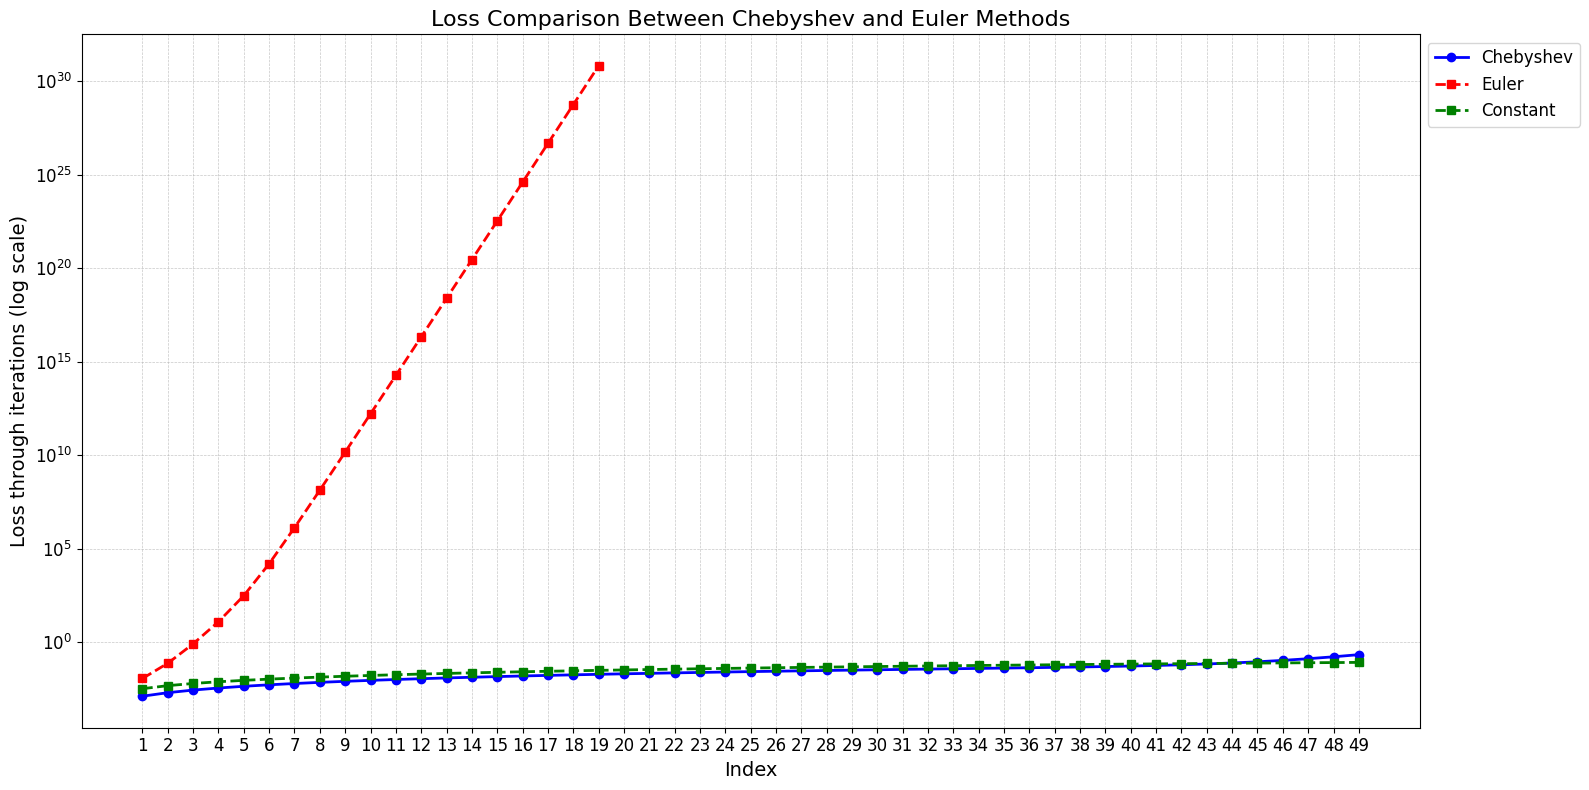

In [34]:
# Create the x values
x = np.arange(1, len(history_euler) + 1)

plt.figure(figsize=(16, 8))
plt.plot(x, history_smoothed, label='Chebyshev', marker='o', color='blue', linestyle='-', linewidth=2, markersize=6)
plt.plot(x, history_euler, label='Euler', marker='s', color='red', linestyle='--', linewidth=2, markersize=6)
plt.plot(x, history_constant, label='Constant', marker='s', color='green', linestyle='--', linewidth=2, markersize=6)

# Set log scale for y axis
plt.yscale('log')

# Set x-ticks from 1 to len(lists)
plt.xticks(x, fontsize=12)
plt.yticks(fontsize=12)

# Add labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Loss through iterations (log scale)', fontsize=14)
plt.title('Loss Comparison Between Chebyshev and Euler Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1,1))

# Customize grid
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

So far so good, we still have many issues:

- It's true that Chebyshev model has a smaller error than Euler integrator, however we must notice that this model is worse than a naive identity model;

- We still don't have the convergence (you can see in the tail of the curve)

- Polynomials are not Universal Approximators, even if we increase $K$, even if we use Chebyshev :(

- We can't have an estimate of the maximum dt we can use!  

### **Graph Convolutional Network**

Finally, it's time to add a bit of "Deep" in this Deep Learning tutorial ;)

First of all, recall the kind of problem we want to solve: we want to build a stable operator that can compute the iterative rule

$$ T^{n+1} = (I - \Delta t D L) \cdot T^{n}$$

such with a bigger $\Delta t$.

The GCN model is a GNN that stabilizes the Adjacency Matrix by normalizing wrt the Degree Node, this step increases the CFL $\Delta t$.

A single GCN step computes the quantity

$$H^{(l+1)} = \sigma\left(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(l)}W^{(l)}\right)$$

with $H^{(l)}$ the $l$-th Hidden Layer, $H^{(0)}:=X$, $\tilde{A}=A+I$ modifyied Adjacency Matrix, $\tilde{D}_{ij}=\sum_j A_{ij}$, the modified Degree Matrix, $W^{(l)}$ the $l$-th Weight Matrix, and $\sigma$ the Activation Function.

For our purpose, we will first use a Residual GCN with Layer Normalization.

In [35]:
class ResidualGCNLayer(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, edge_index:torch.Tensor,
                 edge_weight:torch.Tensor=None, last:bool=False):
        super(ResidualGCNLayer, self).__init__()
        self.last = last
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.gcn = GCNConv(in_channels, out_channels)
        self.layer_norm = nn.LayerNorm(out_channels)
        if in_channels != out_channels:
            self.residual_connection = nn.Linear(in_channels, out_channels)
        else:
            self.residual_connection = None

    def forward(self, x:torch.Tensor):
        identity = x
        out = self.gcn(x, self.edge_index, self.edge_weight)
        if self.residual_connection is not None:
            identity = self.residual_connection(identity)
        out += identity

        if self.last:
            return out

        out = self.layer_norm(out)
        return F.leaky_relu(out)

class Residual_Diffusion_GCN(nn.Module):
    def __init__(self, edge_index:torch.Tensor,
                 edge_weight:torch.Tensor, dt:torch.Tensor,
                 D:torch.Tensor, in_channels:int=1,
                 hidden_channels:int=32, out_channels:int=1, num_layers:int=3):
        super(Residual_Diffusion_GCN, self).__init__()

        self.dt = dt
        self.D = D
        self.layers = nn.ModuleList()
        self.layers.append(ResidualGCNLayer(in_channels, hidden_channels, edge_index=edge_index, edge_weight=edge_weight))
        for _ in range(num_layers - 2):
            self.layers.append(ResidualGCNLayer(hidden_channels, hidden_channels, edge_index=edge_index, edge_weight=edge_weight))
        self.layers.append(ResidualGCNLayer(hidden_channels, out_channels, edge_index=edge_index, edge_weight=edge_weight, last=True))

    def forward(self, x:torch.Tensor):
        x_id = x
        for layer in self.layers:
            x = layer(x)

        return x_id - self.dt*D*x

In [36]:
edge_index_adj = to_undirected(edges)
edge_index_adj, _ = remove_self_loops(edge_index_adj)
edge_index_adj = edge_index_adj.to(device)
weights_dist = vertices.to(device)[edge_index_adj]
weights_dist = 1/torch.norm(weights_dist[0] - weights_dist[1], dim=-1)
weights_dist /= weights_dist.mean() # we can do this easily because all the weights are positive
weight_dist = weights_dist.to(device)

In [37]:
dataset.shape

torch.Size([4, 50, 34834, 1])

In [38]:
dt_new = snap_step * dt_small
# Load the dataset
dataset = torch.load('diffusion_dataset.pt')

D = torch.tensor([D]).to(device)
dt_new = torch.tensor([dt_new]).to(device)
res_gcn_network = Residual_Diffusion_GCN(edge_index_adj, weights_dist, dt_new, D)

# Define the optimizer
optimizer = torch.optim.AdamW(res_gcn_network.parameters(), lr=0.01)
criterion = nn.MSELoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.96)
# Move the model to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
res_gcn_network = res_gcn_network.to(device)
dataset = dataset.to(device)
fixed_points = fixed_points.to(device)

clip_value = 1.0
checkpoint_path_gcn = 'best_res_gcn_network_checkpoint.pt'

train(res_gcn_network, optimizer, scheduler, criterion, dataset, checkpoint_path_gcn, max_T, num_epochs=1000, threshold=2e-2, train=False)

Loading checkpoint...
Checkpoint loaded.


In [ ]:
benchmark_loss_res_gcn = 0
res_gcn_network.eval()
T_pred_res_gcn = dataset[:, 0]
history_res_gcn = []

# Evaluation loop with no_grad context
with torch.no_grad():
    for i in range(dataset.shape[1] - 1):
        T_true = dataset[:, i + 1]  # True temperature distribution at next step

        T_pred_res_gcn = torch.vmap(res_gcn_network, in_dims=(0))(T_pred_res_gcn)
        T_pred_res_gcn = set_fixed_points(T_pred_res_gcn, fixed_points, max_T)
        # Compute the loss
        loss_res_gcn = criterion(T_pred_res_gcn, T_true)

        benchmark_loss_res_gcn += (loss_res_gcn.item() - benchmark_loss_res_gcn)/ (i+1)

        history_res_gcn.append(benchmark_loss_res_gcn)

        print(f"step {i+1}: {benchmark_loss_res_gcn:.6f}")

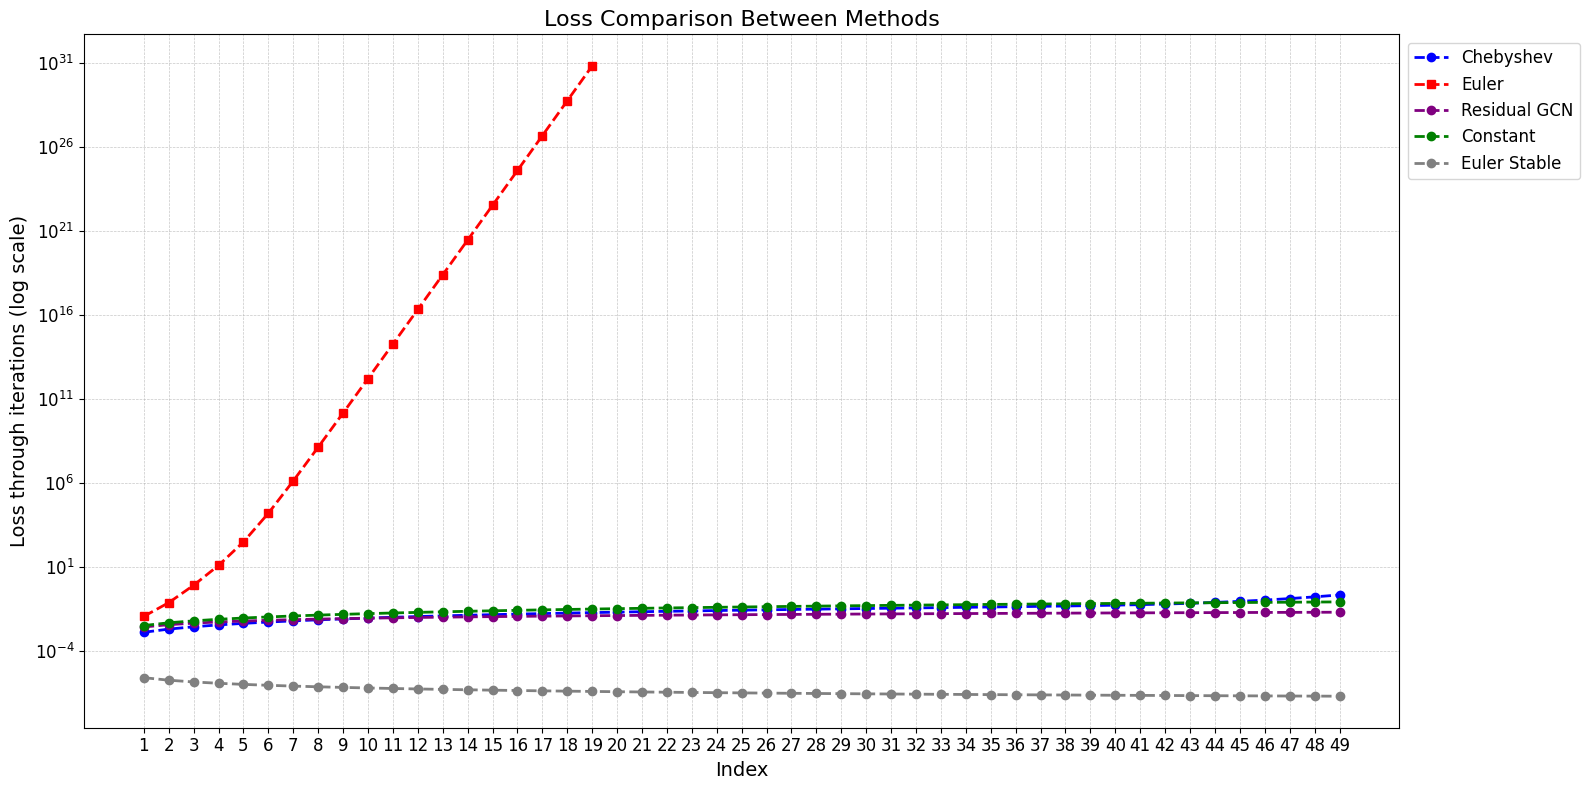

In [40]:
# Create the x values
x = np.arange(1, len(history_euler) + 1)

plt.figure(figsize=(16, 8))
plt.plot(x, history_smoothed, label='Chebyshev', marker='o', color='blue', linestyle='--', linewidth=2, markersize=6)
plt.plot(x, history_euler, label='Euler', marker='s', color='red', linestyle='--', linewidth=2, markersize=6)
plt.plot(x, history_res_gcn, label='Residual GCN', marker='o', color='purple', linestyle='--', linewidth=2, markersize=6)
plt.plot(x, history_constant, label='Constant', marker='o', color='green', linestyle='--', linewidth=2, markersize=6)
plt.plot(x, history_euler_stable, label='Euler Stable', marker='o', color='grey', linestyle='--', linewidth=2, markersize=6)

# Set log scale for y axis
plt.yscale('log')

# Set x-ticks from 1 to len(lists)
plt.xticks(x, fontsize=12)
plt.yticks(fontsize=12)

# Add labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Loss through iterations (log scale)', fontsize=14)
plt.title('Loss Comparison Between Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1,1))

# Customize grid
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

As final improvement, we define the last model, inspired to the previous one, this time we'll use the Normalized Graph Laplacian instead the normalized matrix $I+A$ (we exploit the information coming from Physics)

In [48]:
class ResidualGCNLayer_Improved(nn.Module):
    def __init__(self, in_channels, out_channels, edge_index, edge_weight=None, first:bool=False, last:bool=False):
        super(ResidualGCNLayer_Improved, self).__init__()

        self.first = first
        self.last = last
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.gcn = GCNConv(in_channels, out_channels, normalize=False)
        self.layer_norm = nn.LayerNorm(out_channels)
        if in_channels != out_channels:
            self.residual_connection = nn.Linear(in_channels, out_channels)
        else:
            self.residual_connection = None

    def forward(self, x):

        if self.first:
            return self.gcn(x, self.edge_index, self.edge_weight)

        identity = x

        if self.residual_connection is not None:
            identity = self.residual_connection(identity)

        out = F.leaky_relu(x)
        out = self.gcn(out, self.edge_index, self.edge_weight)
        out += identity
        # if self.last:
        return out

        # return self.layer_norm(out)


class Residual_Diffusion_GCN_Improved(nn.Module):
    def __init__(self, edge_index, edge_weight, dt, D, in_channels=1, hidden_channels=32, out_channels=1, num_layers=3):
        super(Residual_Diffusion_GCN_Improved, self).__init__()

        self.dt = dt
        self.D = D
        self.layers = nn.ModuleList()
        self.layers.append(ResidualGCNLayer_Improved(in_channels, hidden_channels, edge_index=edge_index, edge_weight=edge_weight))
        for _ in range(num_layers - 2):
            self.layers.append(ResidualGCNLayer_Improved(hidden_channels, hidden_channels, edge_index=edge_index, edge_weight=edge_weight))
        self.layers.append(ResidualGCNLayer_Improved(hidden_channels, out_channels, edge_index=edge_index, edge_weight=edge_weight, last=True))

    def forward(self, x):
        x_id = x
        for layer in self.layers:
            x = layer(x)

        return x_id - self.dt*D*x

In [ ]:
dt_new = snap_step * dt_small
# Load the dataset
dataset = torch.load('diffusion_dataset.pt')

edge_index = to_undirected(edges)
edge_index = remove_self_loops(edge_index)[0].to(device)
edge_index_sym, edge_weight_sym = get_laplacian(edge_index, edge_weight=weights_dist, normalization='sym')

D = torch.tensor([D]).to(device)
dt_new = torch.tensor([dt_new]).to(device)
res_gcn_network_improved = Residual_Diffusion_GCN_Improved(edge_index_sym, edge_weight_sym, dt_new, D)

# Define the optimizer
optimizer = torch.optim.AdamW(res_gcn_network_improved.parameters(), lr=0.01)
criterion = nn.MSELoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.97)
# Move the model to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
res_gcn_network_improved = res_gcn_network_improved.to(device)
dataset = dataset.to(device)
fixed_points = fixed_points.to(device)

clip_value = 1.0
checkpoint_path_gcn = 'best_res_gcln2_network_checkpoint.pt'

train(res_gcn_network_improved, optimizer, scheduler, criterion, dataset, checkpoint_path_gcn, max_T, num_epochs=1300, threshold=2e-4, train=True)

In [52]:
benchmark_loss_res_gcn_improved = 0
res_gcn_network_improved.eval()
T_pred_res_gcn_improved = dataset[:, 0]
history_res_gcn_improved = []

# Evaluation loop with no_grad context
with torch.no_grad():
    for i in range(dataset.shape[1] - 1):
        T_true = dataset[:, i + 1]  # True temperature distribution at next step

        T_pred_res_gcn_improved = torch.vmap(res_gcn_network_improved, in_dims=(0))(T_pred_res_gcn_improved)
        T_pred_res_gcn_improved = set_fixed_points(T_pred_res_gcn_improved, fixed_points, max_T)
        # Compute the loss
        loss_res_gcn_improved = criterion(T_pred_res_gcn_improved, T_true)

        benchmark_loss_res_gcn_improved += (loss_res_gcn_improved.item() - benchmark_loss_res_gcn_improved) / (i+1)

        history_res_gcn_improved.append(benchmark_loss_res_gcn_improved)

        print(f"step {i+1}: {benchmark_loss_res_gcn_improved:.6f}")

step 1: 0.000142
step 2: 0.000201
step 3: 0.000288
step 4: 0.000392
step 5: 0.000513
step 6: 0.000648
step 7: 0.000797
step 8: 0.000959
step 9: 0.001133
step 10: 0.001318
step 11: 0.001514
step 12: 0.001719
step 13: 0.001934
step 14: 0.002157
step 15: 0.002389
step 16: 0.002628
step 17: 0.002875
step 18: 0.003128
step 19: 0.003387
step 20: 0.003653
step 21: 0.003924
step 22: 0.004201
step 23: 0.004483
step 24: 0.004769
step 25: 0.005060
step 26: 0.005355
step 27: 0.005654
step 28: 0.005957
step 29: 0.006264
step 30: 0.006574
step 31: 0.006886
step 32: 0.007201
step 33: 0.007519
step 34: 0.007839
step 35: 0.008162
step 36: 0.008488
step 37: 0.008817
step 38: 0.009151
step 39: 0.009490
step 40: 0.009835
step 41: 0.010184
step 42: 0.010543
step 43: 0.010907
step 44: 0.011286
step 45: 0.011666
step 46: 0.012066
step 47: 0.012468
step 48: 0.012894
step 49: 0.013316


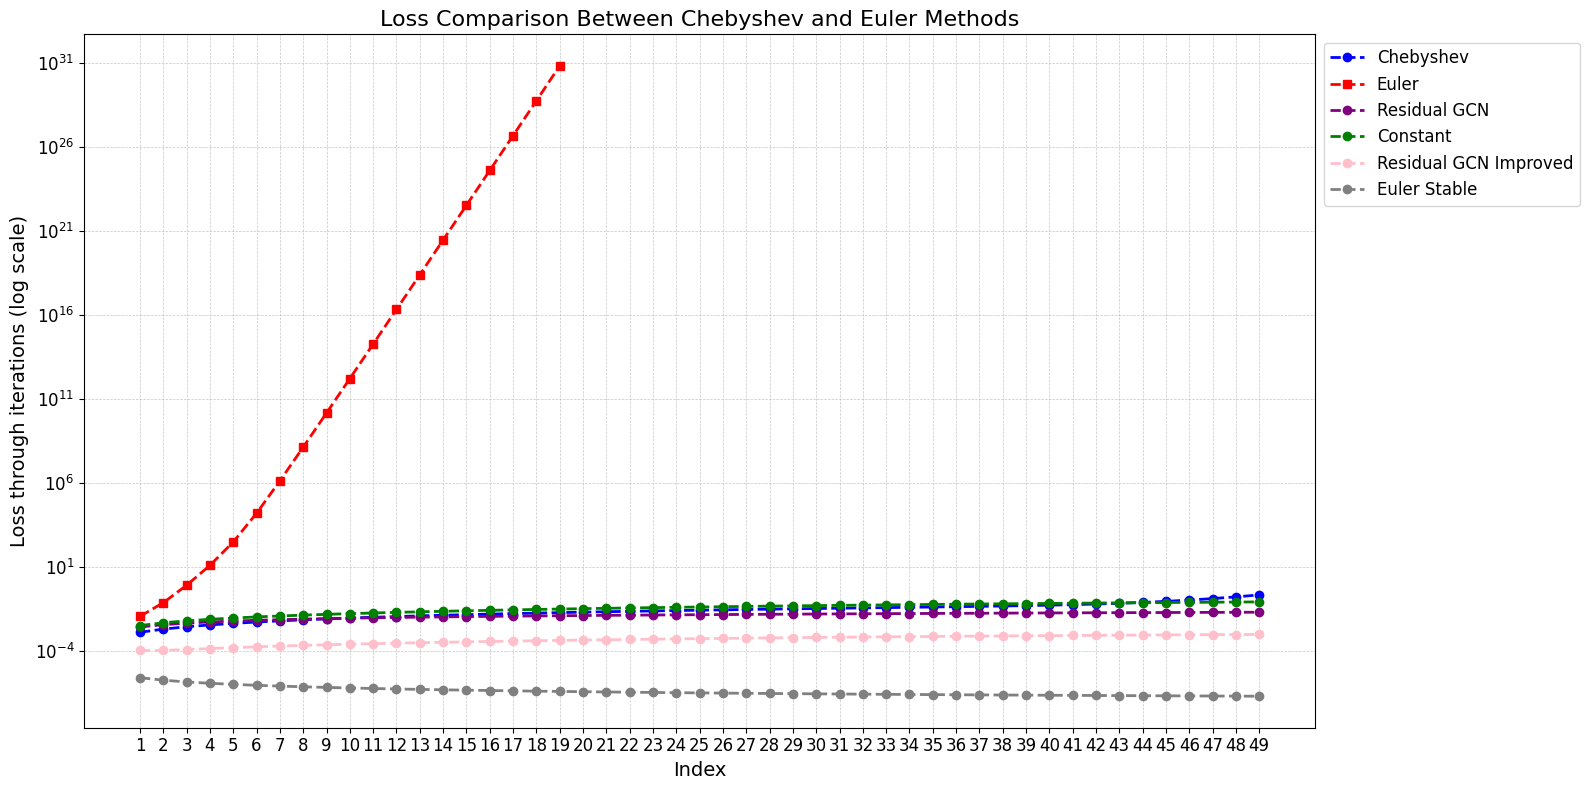

In [44]:
# Create the x values
x = np.arange(1, len(history_euler) + 1)

plt.figure(figsize=(16, 8))
plt.plot(x, history_smoothed, label='Chebyshev', marker='o', color='blue', linestyle='--', linewidth=2, markersize=6)
plt.plot(x, history_euler, label='Euler', marker='s', color='red', linestyle='--', linewidth=2, markersize=6)
plt.plot(x, history_res_gcn, label='Residual GCN', marker='o', color='purple', linestyle='--', linewidth=2, markersize=6)
plt.plot(x, history_constant, label='Constant', marker='o', color='green', linestyle='--', linewidth=2, markersize=6)
plt.plot(x, history_res_gcn_improved, label='Residual GCN Improved', marker='o', color='pink', linestyle='--', linewidth=2, markersize=6)
plt.plot(x, history_euler_stable, label='Euler Stable', marker='o', color='grey', linestyle='--', linewidth=2, markersize=6)

# Set log scale for y axis
plt.yscale('log')

# Set x-ticks from 1 to len(lists)
plt.xticks(x, fontsize=12)
plt.yticks(fontsize=12)

# Add labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Loss through iterations (log scale)', fontsize=14)
plt.title('Loss Comparison Between Chebyshev and Euler Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1,1))

# Customize grid
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

As you can see, the loss of the last model is the best (except for the Euler Model in the stable regime), of course we can try to improve further by using autoencoders, and RNNs, but for this tutorial that's all :)